## DEMO MLP

In [1]:
import sys
sys.path.append('../../TINY/')
import TINY 
import UTILS
from mes_imports import *
import load_data_Loader
import SOLVE_EB as EB

We define the name of the layer by 
- 'L' for a linear layer
- 'CB' for a convolutional followed by a batchnorm


In [2]:
layer_name = {1 : 'L', 2 : 'L', 3 :'L'}

We define the starting size of the model by the number of neurons in the starting architecture. In this example we start with 5 neurons by hidden layers.
The last layer should be of the size of the prediction. For the MNIST dataset there is 10 classes so the size of the last layer is 10.

In [3]:
skeleton = {0: {}, 1 : {'size' : 5}, 2 : {'size' : 5}, 3 : {'size' : 10}}

We select the activation function for all layers. In this notebook as we use the CrossEntropy loss https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html we choose the Identity for the activation function at the last layer.

In [4]:
fct = {depth : torch.nn.ReLU() for depth in range(1, 3)}
fct.update({3 : torch.nn.Identity()})

We define the loss function :

In [5]:
### Loss function ###
def Loss_entropy(x1, x2, reduction = 'mean') :
    #print(x1.shape, x2.shape)
    return(torch.nn.CrossEntropyLoss(reduction = reduction)(x1, x2))


## MLP

In [6]:
dico_parameters = {
                 'skeleton' : copy.deepcopy(skeleton),
                'Loss' : Loss_entropy,
                'fct' : fct,
                'layer_name' :layer_name,
                'init_deplacement' : 1e-8, # min amplitude factor
                'batch_size' : 64,# batchsize for training
                'lr' : 1e-2,# leraning rate for training
                'lambda_method' : 0, # = 0 for searching the amplitude factor, if > 0 the 
                                     # amplitude factor is automatically set to this value
                'accroissement_decay' : 1e-4,# the minimum decay to update the 
                                             # architecture with the NewNeurons/BestUpdate 
                'depth_seuil' : {1 : 10, 2 : 10},
                'lu_lin' : 2,
                'max_batch_estimation' : 100,
                'max_amplitude' : 20., # max amplitude factor
                'ind_lmbda_shape' : 1000,
                'init_X_shape' : [1, 28, 28], # size of the input, if your X are 1-d, unsqueeze them
                'len_train_dataset' : 50000, # size of training data
                'len_test_dataset' : 10000, # size of testing data
                'selection_neuron' : UTILS.selection_neuron_seuil,
                'how_to_define_batchsize' : UTILS.indices_non_constant,
                }


In [7]:
MLP_model = TINY.TINY(dico_parameters)
MLP_model.training_data, MLP_model.test_data = load_data_Loader.load_database_MNIST(batch_size = MLP_model.max_batch_estimation)
MLP_model.tr_loader, MLP_model.te_loader =  DataLoader(MLP_model.training_data, batch_size=MLP_model.batch_size, shuffle=True),  DataLoader(MLP_model.test_data, batch_size=MLP_model.batch_size, shuffle=True)

In [8]:
MLP_model.layer

{1: {'L': Linear(in_features=784, out_features=5, bias=True)},
 2: {'L': Linear(in_features=5, out_features=5, bias=True)},
 3: {'L': Linear(in_features=5, out_features=10, bias=True)}}

The starting performances are :

In [9]:
X, Y = MLP_model.get_batch(data = 'tr', device = my_device_0) # parametres par défault
X_te, Y_te =  MLP_model.get_batch(data = 'te', device = my_device_0)

In [10]:
with torch.no_grad() :
    print('Loss on train :', MLP_model.Loss(Y, MLP_model(X)).item(), ' || Loss on test :', MLP_model.Loss(Y_te, MLP_model(X_te)).item())
    print('Accuracy on train :', UTILS.calculate_accuracy(Y, MLP_model(X)), ' || Accuracy on test :', UTILS.calculate_accuracy(Y_te, MLP_model(X_te)))

Loss on train : 3.7904253005981445  || Loss on test : 3.794570207595825
Accuracy on train : 0.0625  || Accuracy on test : 0.015625


You can acces the basic functions of your model in the module TINY
- count_parameters, count_parameters_layer, get_parameters, ....
- get_batch, train_batch, ...

In [11]:
optimizer = torch.optim.SGD(MLP_model.parameters(), lr = 1e-4)
L_tr, L_te, _, A_tr, A_te, _, T = MLP_model.train_batch(optimizer = optimizer, nbr_epoch = 0.01)

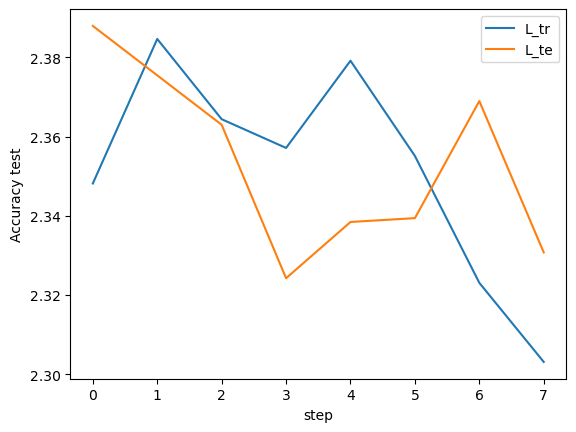

In [12]:
plt.plot(L_tr, label = 'L_tr')
plt.plot(L_te, label = 'L_te')
plt.xlabel('step')
plt.ylabel('Accuracy test')
plt.legend()
plt.show()

## architecture growth and training

In [13]:
df_tracker = pd.DataFrame()
A_tr, A_te, L_tr, L_te, T = np.array([]), np.array([]), np.array([]), np.array([]), np.array([0])
to_add = [1, 2] ##  depth where neurons can be added
nbr_pass = 20
nbr_epochs_betw_adding = 0.5 ## Epochs of training between adding

name_file_expe = 'resultats/' 

In [14]:
def update_quantity_of_interest() :
    global L_tr, L_te, A_tr, A_te, T, df_tracker
    dico_tracker = {'vps' + str(i) : [ MLP_model.valeurs_propres[i].item()] for i in range(len(MLP_model.valeurs_propres))}
    
    dico_tracker.update({'depth_add' : best_depth, 'nbr_added_neuron': MLP_model.nbr_added_neuron})
    dico_tracker.update({'accroissement' : [dico_EB[best_depth]['accroissement']], 'portion_gain' : [dico_EB[best_depth]['portion_gain']],
                        'nbr_parameters_apres' : [MLP_model.count_parameters()], 'nbr_parameters_avant' : [nbr_parameters_avant],
                        'T' : [T[-1]], 'len_L_tr' : [len(L_tr)], 'lu_conv' : [MLP_model.lu_conv]})
    
    df_tracker = pd.concat([df_tracker, pd.DataFrame.from_dict(dico_tracker)], ignore_index=True)
    
    L_tr = np.concatenate([L_tr, l_tr])
    L_te = np.concatenate([L_te, l_te])
    A_tr = np.concatenate([A_tr, a_tr])
    A_te = np.concatenate([A_te, a_te])
    T = np.concatenate([T, t +  T[-1]])

    
    
def stabilize_training() :
    MLP_model.batch_size = math.ceil(np.sqrt(MLP_model.count_parameters() / nbr_parameters_avant) *  MLP_model.batch_size)
    #MLP_model.batch_size = math.ceil(MLP_model.count_parameters() / nbr_parameters_avant *  MLP_model.batch_size)

In [15]:
count = 1

In [21]:
for j in tqdm(range(5)) :
    for k in range(len(to_add)) :
        nbr_parameters_avant = MLP_model.count_parameters()
        gc.collect()
        torch.cuda.empty_cache()
        depth_ajout = to_add
        depth_in_decreasing_criterion, dico_EB = EB.where_is_EB_best_solved(MLP_model, depths = depth_ajout)

        best_depth = depth_in_decreasing_criterion[0]
        dico_EB_bd = dico_EB[best_depth]
        alpha, omega, bias_alpha, vps = dico_EB_bd['alpha'], dico_EB_bd['omega'], dico_EB_bd['bias_alpha'], dico_EB_bd['vps']
        lambda_method = dico_EB_bd['beta_min']

        MLP_model.alpha, MLP_model.omega, MLP_model.bias_alpha, MLP_model.valeurs_propres = None, None, None, []
        MLP_model.TAB_Add = None

        
        if lambda_method > 0 :
            MLP_model.dico_w, MLP_model.lambda_method = dico_EB_bd['dico_w'], dico_EB_bd['beta_min']
            EB.add_neurons(MLP_model, best_depth, alpha = alpha, omega = omega, bias_alpha = bias_alpha, valeurs_propres = vps)
            MLP_model.lambda_method = torch.tensor(0., device = my_device_0)
        ## Training Loops ##
        
        stabilize_training()
        MLP_model.tr_loader = DataLoader(MLP_model.training_data, batch_size=MLP_model.batch_size, shuffle=True)
        MLP_model.te_loader = DataLoader(MLP_model.test_data, batch_size=MLP_model.batch_size, shuffle=True)
        optimizer = torch.optim.SGD(MLP_model.parameters(), lr = MLP_model.lr)
        
        l_tr, l_te, l_va, a_tr, a_te, a_va, t = MLP_model.train_batch(nbr_epochs_betw_adding, optimizer = optimizer)

        update_quantity_of_interest()
    
    df_performance = pd.DataFrame.from_dict({'L_tr' : L_tr, 'L_te' : L_te, 'A_tr' : A_tr, 'A_te' : A_te, 'T' : T[1:], 
                                             'BatchSize' : np.ones(A_te.shape) * MLP_model.batch_size})
    df_tracker.to_csv(name_file_expe + '/df_tracker.csv')
    df_performance.to_csv(name_file_expe + '/df_performance.csv')
    MLP_model.T = T[-1]
    MLP_model.len_L_tr = len(L_tr)
    UTILS.save_model_to_file(MLP_model, path = name_file_expe + '/' , name='model_' + str((j + 1) * (k + 1)))





  0%|          | 0/5 [00:00<?, ?it/s]



*** started  NG at  2 ***
Batch size for estimation : 12300


*** started  Add at  1 ***
Batch size for estimation : 50000
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 29.652645111083984
norm_x_over_norm_DE_depthp1 :  87.47142028808594
L_plus < L_moins: 0.31858113408088684 < 0.31858134269714355
Delta Loss :  [0.0, 5.960464477539063e-08]  ... [0.0, 5.960464477539063e-08]
betas :  [0.0, 7.450580596923828e-09] ... [0.0, 7.450580596923828e-09]
rate of decrease : 0.0 ampli_fct : 0.0 L[0] : 0.28121301531791687


*** started  NG at  3 ***
Batch size for estimation : 2300
*** SINGULAR MATRIX ***


*** started  Add at  2 ***
Batch size for estimation : 1100
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 62.41836166381836
norm_x_over_norm_DE_depthp1 :  253.85652160644

*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 64.71578979492188
norm_x_over_norm_DE_depthp1 :  255.57113647460938
L_plus < L_moins: 0.16742917895317078 < 0.16743502020835876
Delta Loss :  [0.0, 1.8328428268432617e-06]  ... [0.0, 1.8328428268432617e-06]
betas :  [0.0, 7.450580596923828e-09] ... [0.0, 7.450580596923828e-09]
rate of decrease : 0.0 ampli_fct : 0.0 L[0] : 0.2121298760175705


*** started  NG at  2 ***
Batch size for estimation : 19700


*** started  Add at  1 ***
Batch size for estimation : 50000
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 36.49835968017578
norm_x_over_norm_DE_depthp1 :  309.9521484375
L_plus < L_moins: 0.49035969376564026 < 0.49036043882369995
Delta Loss :  [0.0, 1.4901161193847656e-08]  ... [0.0, 1.4901161193847656e-08]
betas :

*** SINGULAR MATRIX ***


*** started  Add at  2 ***
Batch size for estimation : 1700
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 71.15719604492188
norm_x_over_norm_DE_depthp1 :  231.5941162109375
L_plus < L_moins: 0.14939439296722412 < 0.149394690990448
Delta Loss :  [0.0, -3.8743019104003906e-07, -7.152557373046875e-07]  ... [-0.0055994391441345215, -0.008612215518951416, -0.005084872245788574]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0001220703125, 0.000244140625, 0.00048828125]
rate of decrease : 0.01804632507264614 ampli_fct : 0.000244140625 L[0] : 0.47722822427749634


*** started  Add at  2 ***
Batch size for estimation : 1700
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.6874070167541504
norm_x_over_norm_DE_depthp1 :  0.01130963210016489
amplitude factor for the n

In [22]:
#MLP

In [23]:
#UTILS.save_model_to_file(MLP_model, path = name_file_expe + '/' , name='model_' + str((j + 1) * (k + 1)))


### Plotting

In [24]:
path = 'resultats/'

In [25]:
df_tracker = pd.read_csv(path + 'df_tracker.csv')
df_performance = pd.read_csv(path + 'df_performance.csv')

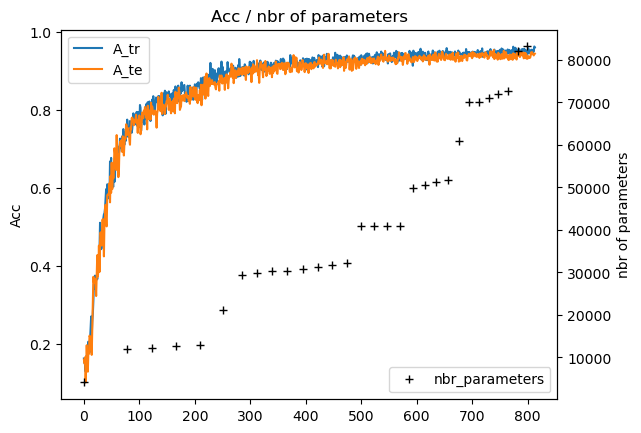

In [26]:
fig, ax = plt.subplots(1, 1)
coef = 5
ax.plot(UTILS.lisser_courbe(df_performance[['A_tr', 'A_te']], coef = coef), label = ['A_tr', 'A_te'])
ax.legend()
ax_nbrp = ax.twinx()
ax_nbrp.plot(df_tracker['len_L_tr'] / coef, df_tracker['nbr_parameters_apres'], '+', label = 'nbr_parameters', color = 'black')
ax_nbrp.legend(loc = 'lower right')
ax.set_title('Acc / nbr of parameters')
ax.set_ylabel('Acc')
ax_nbrp.set_ylabel('nbr of parameters')
plt.show()

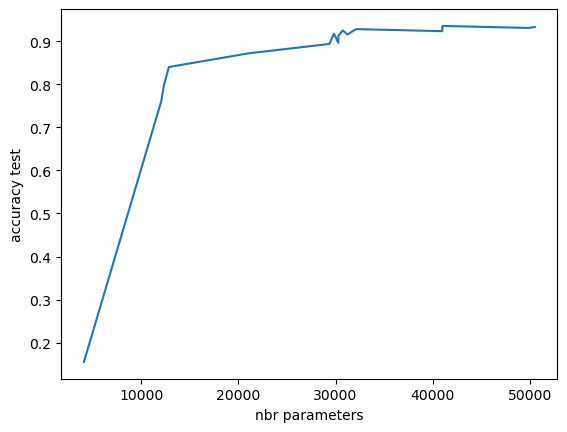

In [20]:
coef = 10
plt.plot(df_tracker['nbr_parameters_apres'], UTILS.lisser_courbe(df_performance['A_te'].values, coef = coef)[(df_tracker['len_L_tr'].values /coef).astype(int)])
plt.xlabel('nbr parameters')
plt.ylabel('accuracy test')
plt.show()

In [51]:
MLP_model.skeleton

{0: {'size': 784}, 1: {'size': 30}, 2: {'size': 75}, 3: {'size': 10}}

In [52]:
df_performance[['A_tr', 'A_te']][-20:].mean(axis = 0)

A_tr    0.947126
A_te    0.922126
dtype: float64